# Modelo Final de Previsão de Preços em São Paulo
Este notebook contém o script limpo e consolidado para executar o modelo XGBoost e a função de previsão interativa. Ele removeu todas as células de Análise Exploratória de Dados (EDA) e testes de avaliação para focar na aplicação.

#### 1. Configuração e Importações Necessárias
Importa as bibliotecas essenciais para manipulação de dados, pré-processamento e o modelo XGBoost.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor as xgb
from sklearn.pipeline import Pipeline # Mantido para tipagem e compatibilidade
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

#### 2. Preparação de Dados e Mapeamento de Regiões
Este bloco carrega o dataset, aplica os filtros de limpeza e define o mapeamento completo dos bairros para suas respectivas zonas, que é crucial para o encoding categórico do modelo.

Atenção: Você precisa ajustar o caminho_csv para onde o seu arquivo está salvo.

In [2]:
# ⚠️ AJUSTE O CAMINHO DO SEU ARQUIVO CSV AQUI ⚠️
try:
    caminho_csv = r'C:\Users\luuka\.cache\kagglehub\datasets\argonalyst\sao-paulo-real-estate-sale-rent-april-2019\versions\1\sao-paulo-properties-april-2019.csv' 
    df = pd.read_csv(caminho_csv)
    print("Base de dados carregada com sucesso.")
except FileNotFoundError:
    print("ERRO: O arquivo CSV não foi encontrado. Verifique o caminho.")
    raise

# Filtros e tratamento de dados (Baseado nas etapas do seu notebook original)
df = df[df['Negotiation Type'] == 'sale'].drop(columns=['Negotiation Type', 'Property Type'])
df.dropna(subset=['Price', 'Condo'], inplace=True)
df['bairro'] = df['District'].apply(lambda x: x.split('/')[0].strip())

# Definição Completa do Dicionário de Mapeamento (mapeamento_regioes)
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim': 'Zona Leste', 'Cangaíba': 'Zona Leste', 'Carrão': 'Zona Leste', 
    'Cidade Líder': 'Zona Leste', 'Cidade Tiradentes': 'Zona Leste', 'Ermelino Matarazzo': 'Zona Leste', 
    'Itaim Paulista': 'Zona Leste', 'Itaquera': 'Zona Leste', 'Jardim Helena': 'Zona Leste', 
    'José Bonifácio': 'Zona Leste', 'Lajeado': 'Zona Leste', 'Parque do Carmo': 'Zona Leste', 
    'Ponte Rasa': 'Zona Leste', 'São Mateus': 'Zona Leste', 'São Miguel': 'Zona Leste', 
    'São Rafael': 'Zona Leste', 'Vila Curuçá': 'Zona Leste', 'Vila Formosa': 'Zona Leste', 
    'Aricanduva': 'Zona Leste', 'Guaianazes': 'Zona Leste', 'Penha': 'Zona Leste', 
    'Tatuapé': 'Zona Leste', 'Vila Matilde': 'Zona Leste', 'Mooca': 'Zona Leste', 
    'Belém': 'Zona Leste', 'Água Rasa': 'Zona Leste', 'Sapopemba': 'Zona Leste', 
    'São Lucas': 'Zona Leste', 'Vila Jacuí': 'Zona Leste', 'Vila Prudente': 'Zona Leste', 
    'Iguatemi': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo': 'Zona Sul', 'Campo Grande': 'Zona Sul', 'Campo Limpo': 'Zona Sul', 
    'Capão Redondo': 'Zona Sul', 'Cidade Ademar': 'Zona Sul', 'Cidade Dutra': 'Zona Sul', 
    'Grajaú': 'Zona Sul', 'Ipiranga': 'Zona Sul', 'Itaim Bibi': 'Zona Sul', 
    'Jabaquara': 'Zona Sul', 'Jardim Ângela': 'Zona Sul', 'Jardim Paulista': 'Zona Sul', 
    'Moema': 'Zona Sul', 'Morumbi': 'Zona Sul', 'Sacomã': 'Zona Sul', 
    'Santo Amaro': 'Zona Sul', 'Saúde': 'Zona Sul', 'Socorro': 'Zona Sul', 
    'Vila Andrade': 'Zona Sul', 'Vila Mariana': 'Zona Sul', 'Vila Sônia': 'Zona Sul', 
    'Brooklin': 'Zona Sul', 'Vila Olimpia': 'Zona Sul', 'Pedreira': 'Zona Sul', 
    'Cursino': 'Zona Sul', 'Cambuci': 'Zona Sul', 'Jardim São Luis': 'Zona Sul', 
    
    # Zona Oeste
    'Alto de Pinheiros': 'Zona Oeste', 'Butantã': 'Zona Oeste', 'Jaguaré': 'Zona Oeste', 
    'Lapa': 'Zona Oeste', 'Perdizes': 'Zona Oeste', 'Pinheiros': 'Zona Oeste', 
    'Vila Leopoldina': 'Zona Oeste', 'Vila Madalena': 'Zona Oeste', 'Raposo Tavares': 'Zona Oeste', 
    'Rio Pequeno': 'Zona Oeste', 'Pirituba': 'Zona Oeste', 'Perus': 'Zona Oeste', 
    'Anhanguera': 'Zona Oeste', 'Jaraguá': 'Zona Oeste', 'São Domingos': 'Zona Oeste', 
    
    # Zona Norte
    'Casa Verde': 'Zona Norte', 'Santana': 'Zona Norte', 'Tucuruvi': 'Zona Norte', 
    'Mandaqui': 'Zona Norte', 'Tremembé': 'Zona Norte', 'Vila Guilherme': 'Zona Norte', 
    'Vila Maria': 'Zona Norte', 'Jaçanã': 'Zona Norte', 'Brasilândia': 'Zona Norte', 
    'Freguesia do Ó': 'Zona Norte', 'Limão': 'Zona Norte', 'Cachoeirinha': 'Zona Norte', 
    'Medeiros': 'Zona Norte', 
    
    # Centro
    'Barra Funda': 'Centro', 'Bela Vista': 'Centro', 'Bom Retiro': 'Centro', 
    'Brás': 'Centro', 'Consolação': 'Centro', 'Liberdade': 'Centro', 
    'República': 'Centro', 'Santa Cecília': 'Centro', 'Sé': 'Centro', 
    'Pari': 'Centro'
}

df['Regiao'] = df['bairro'].apply(lambda x: mapeamento_regioes.get(x, 'Outras'))

# Filtra o DF apenas para os bairros mapeados para evitar que o encoder veja categorias que não podem ser inseridas
bairros_mapeados = list(mapeamento_regioes.keys())
df = df[df['bairro'].isin(bairros_mapeados)].copy()

Base de dados carregada com sucesso.


#### 3. Ajuste da Variável Alvo (Price)
Esta seção foca em realizar um ajuste na variável alvo, e trazer a valor presente atualizada pelo IGPM.

In [3]:
# Definir o multiplicador do IGPM e criar a coluna atualizada
IGPM_MULTIPLIER = 1.6571
df['Price_atualizado'] = df['Price'] * IGPM_MULTIPLIER


#### 4.1. Análise Detalhada por Bairro (Mediana e Contagem)
Os gráficos de Mediana de Preço neste bloco agora refletem os valores ajustados pelo IGP-M.

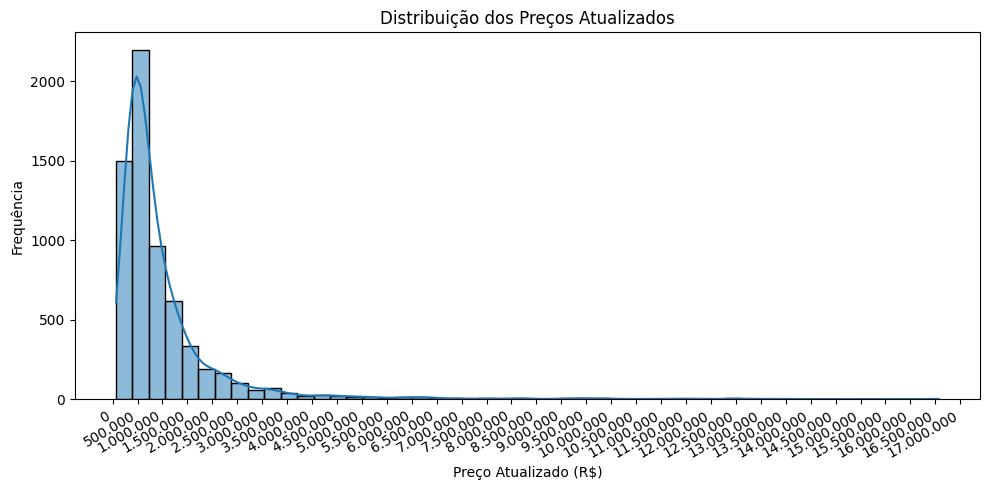

In [4]:
plt.figure(figsize=(10, 5)) 
ax = sns.histplot(df['Price_atualizado'], bins=50, kde=True) 
plt.title('Distribuição dos Preços Atualizados')
plt.xlabel('Preço Atualizado (R$)')
plt.ylabel('Frequência')

# 1. Desativa a notação científica
plt.ticklabel_format(style='plain', axis='x')

# 2. Formata os números para o padrão brasileiro (ex: 1.000.000)
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
ax.xaxis.set_major_formatter(formatter)

# 3. Define manualmente os locais dos ticks no eixo X
ticks = np.arange(0, df['Price_atualizado'].max() + 500_000, 500_000)
plt.xticks(ticks, rotation=30, ha='right') 

plt.tight_layout() 
plt.show()


C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\2256231311.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='viridis')
C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\2256231311.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Median_Price_Atualizada', y='Bairro', data=bairro_price_top, palette='magma')


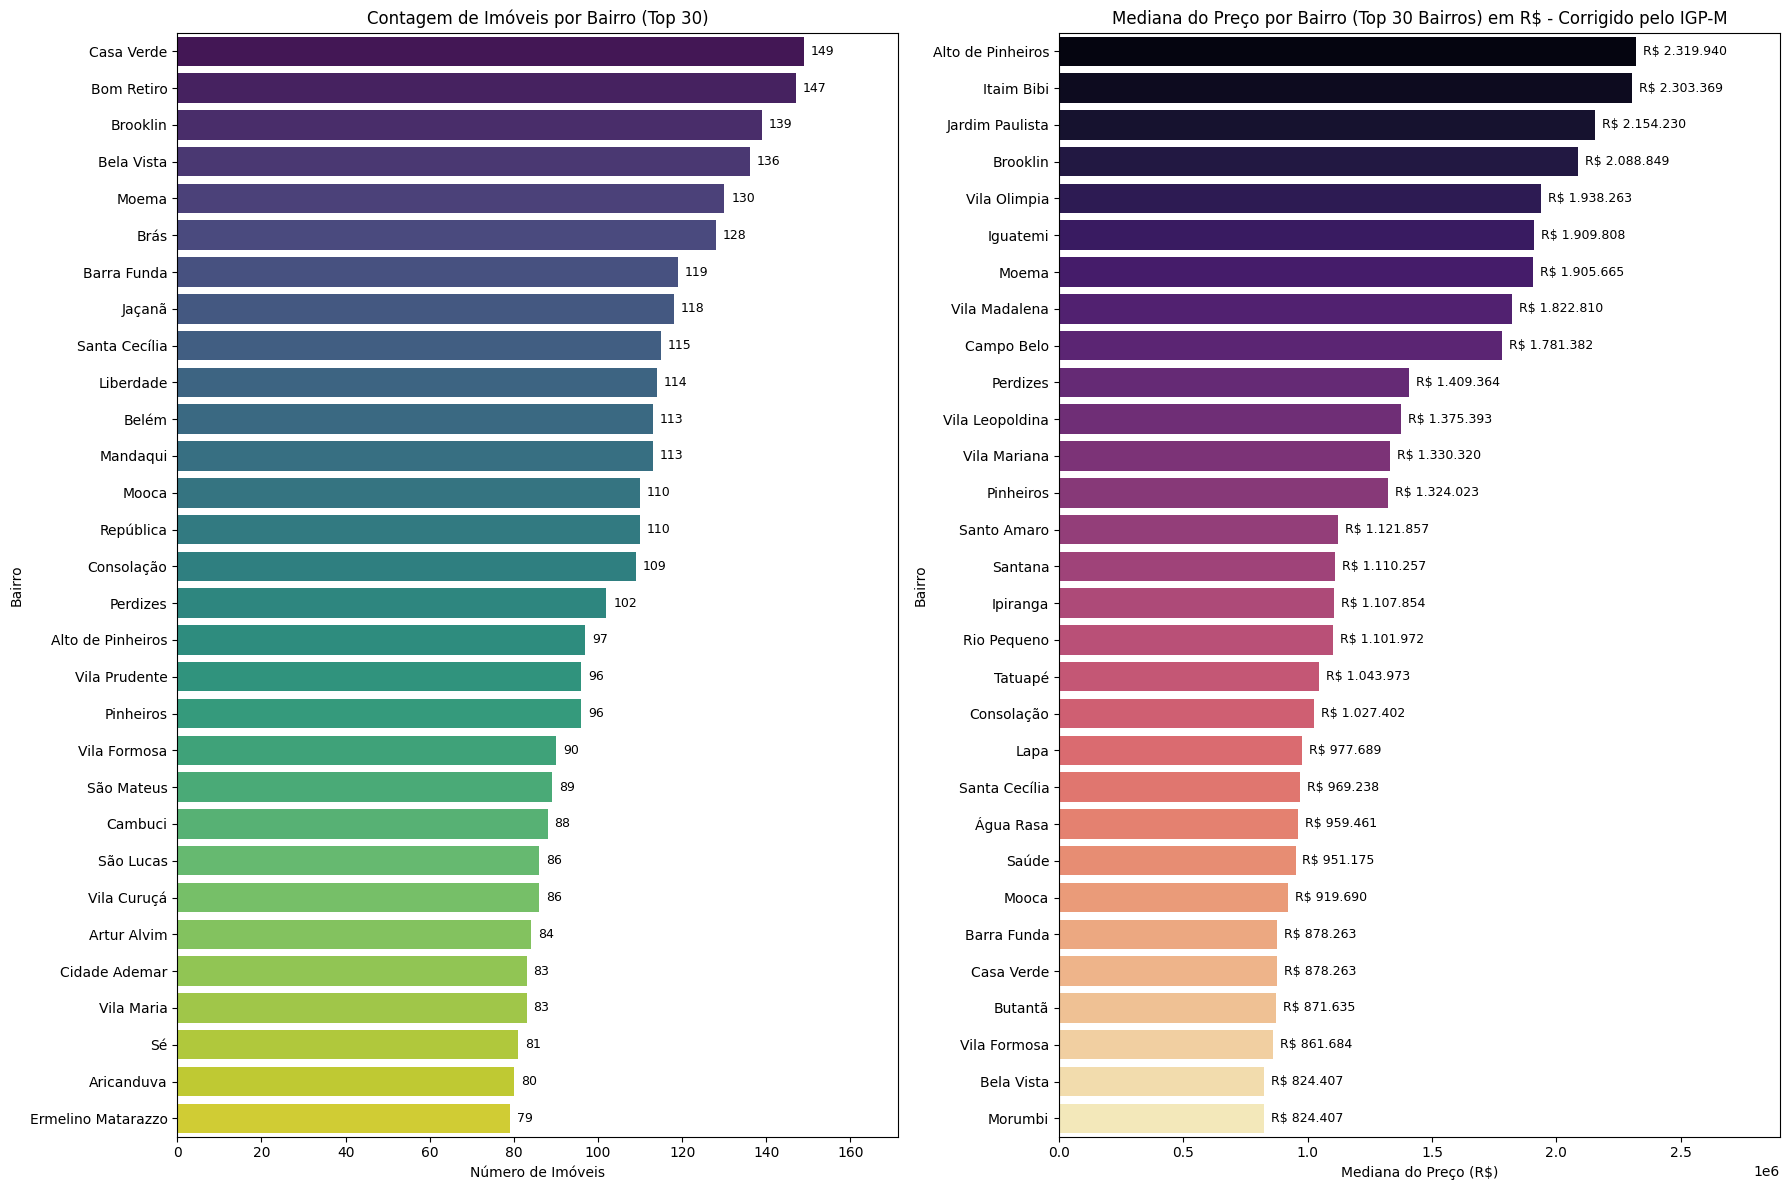

In [5]:
plt.figure(figsize=(18, 12)) 

# Contagem de Imóveis por Bairro (Top 30) - COM RÓTULOS
plt.subplot(1, 2, 1)

bairro_counts = df['bairro'].value_counts().head(30)
ax1 = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='viridis')
plt.title('Contagem de Imóveis por Bairro (Top 30)')
plt.xlabel('Número de Imóveis')
plt.ylabel('Bairro')

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)
    
ax1.set_xlim(right=bairro_counts.max() * 1.15)

# ----------------------------------------------------
# Mediana do Preço (R$) por BAIRRO (Top 30) - AJUSTADA PELO IGPM
plt.subplot(1, 2, 2)

# 1. Agrupa por 'bairro' e calcula a Mediana da coluna ATUALIZADA
bairro_price_median = df.groupby('bairro')['Price_atualizado'].median().sort_values(ascending=False).reset_index()
bairro_price_median.columns = ['Bairro', 'Median_Price_Atualizada']

# 2. Seleciona os Top 30 bairros com a mediana mais alta
top_n = 30
bairro_price_top = bairro_price_median.head(top_n)

# 3. Cria o gráfico de barras
ax2 = sns.barplot(x='Median_Price_Atualizada', y='Bairro', data=bairro_price_top, palette='magma')
plt.title(f'Mediana do Preço por Bairro (Top {top_n} Bairros) em R$ - Corrigido pelo IGP-M')
plt.xlabel('Mediana do Preço (R$)')
plt.ylabel('Bairro')

# 4. Adiciona os rótulos de dados (Preço em R$)
for p in ax2.patches:
    # Formata o valor como R$ X.XXX.XXX
    value = f"R$ {p.get_width():,.0f}".replace(',', '_').replace('.', ',').replace('_', '.')
    
    ax2.annotate(value, 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)

ax2.set_xlim(right=bairro_price_top['Median_Price_Atualizada'].max() * 1.25)


plt.tight_layout()
plt.show()

C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\1496320768.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Mediana_Preco_M2', y='Bairro', data=bairro_m2_top, palette='viridis')


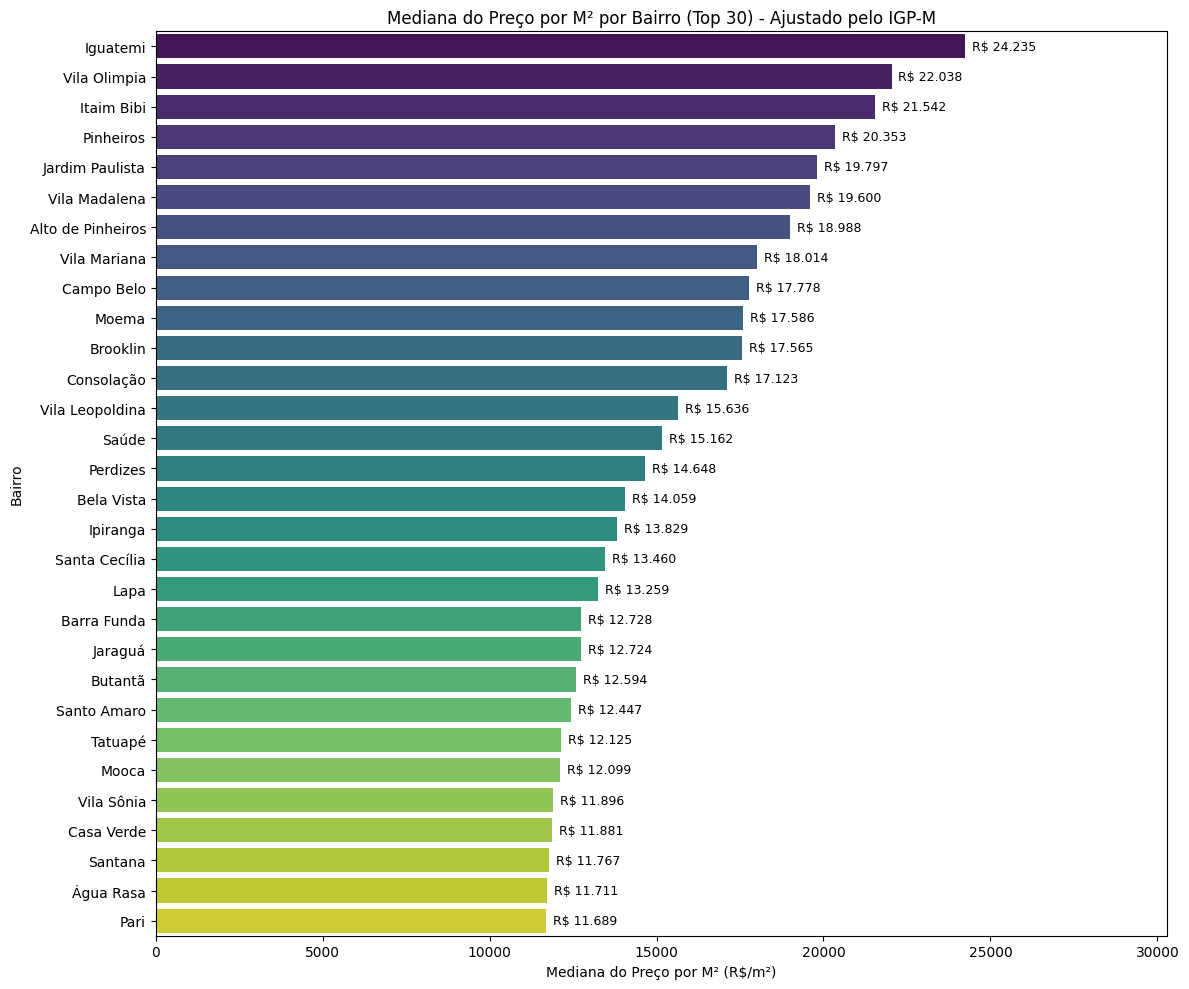


Top 5 Bairros por Mediana de Preço/M² (R$/m²):
            Bairro  Mediana_Preco_M2
0         Iguatemi           24235.0
1     Vila Olimpia           22038.0
2       Itaim Bibi           21542.0
3        Pinheiros           20353.0
4  Jardim Paulista           19797.0


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Criar a métrica R$/m² (usando o preço ajustado)
df['preco_m2_ajustado'] = df['Price_atualizado'] / df['Size']

# 2. Calcular a Mediana do R$/m² por Bairro
# A mediana é mais robusta contra outliers extremos do que a média.
m2_median_por_bairro = df.groupby('bairro')['preco_m2_ajustado'].median().sort_values(ascending=False).reset_index()
m2_median_por_bairro.columns = ['Bairro', 'Mediana_Preco_M2']

# 3. Selecionar os Top 30 Bairros para visualização
top_n = 30
bairro_m2_top = m2_median_por_bairro.head(top_n)

# 4. Gerar o gráfico de barras
plt.figure(figsize=(12, 10))

ax = sns.barplot(x='Mediana_Preco_M2', y='Bairro', data=bairro_m2_top, palette='viridis')
plt.title(f'Mediana do Preço por M² por Bairro (Top {top_n}) - Ajustado pelo IGP-M')
plt.xlabel('Mediana do Preço por M² (R$/m²)')
plt.ylabel('Bairro')

# 5. Adicionar rótulos de dados (Data Labels)
for p in ax.patches:
    # Formata o valor como R$ X.XXX (inteiro sem casas decimais)
    value = f"R$ {p.get_width():,.0f}".replace(',', '_').replace('.', ',').replace('_', '.')
    
    ax.annotate(value, 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)

# Ajusta o limite do eixo X para dar espaço aos rótulos
ax.set_xlim(right=bairro_m2_top['Mediana_Preco_M2'].max() * 1.25)

plt.tight_layout()
plt.show()

# Exibe os 5 bairros com a Mediana de Preço/m² mais alta para referência
print("\nTop 5 Bairros por Mediana de Preço/M² (R$/m²):")
print(bairro_m2_top.head(5).round(0))

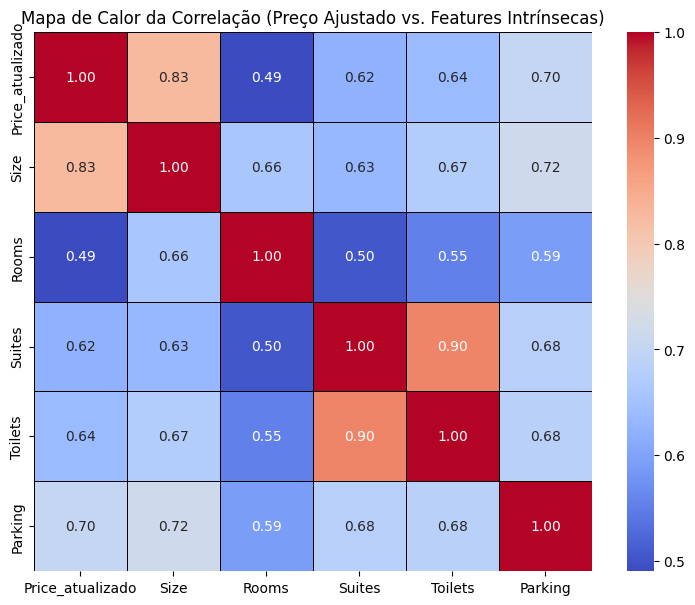


Correlação do Preço Atualizado com as Features:
Price_atualizado    1.00
Size                0.83
Parking             0.70
Toilets             0.64
Suites              0.62
Rooms               0.49
Name: Price_atualizado, dtype: float64


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NOTA: O 'df' deve ter a coluna 'Price_atualizado' criada em uma célula anterior
# Se você não a criou, descomente e execute a linha abaixo:
# IGPM_MULTIPLIER = 1.6571
# df['Price_atualizado'] = df['Price'] * IGPM_MULTIPLIER

# 1. Definir as features para análise
features_numericas = ['Price_atualizado', 'Size', 'Rooms', 'Suites', 'Toilets', 'Parking']

# 2. Calcular a Matriz de Correlação
# Usamos a Correlação de Pearson
corr_matrix = df[features_numericas].corr()

# 3. Gerar o Mapa de Calor
plt.figure(figsize=(9, 7))

# Configurações do Heatmap:
# annot=True: Mostra o valor da correlação dentro de cada célula
# fmt=".2f": Formata o número com 2 casas decimais
# cmap='coolwarm': Usa um esquema de cores que destaca correlação positiva (vermelho) e negativa (azul)
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5, 
            linecolor='black')

plt.title('Mapa de Calor da Correlação (Preço Ajustado vs. Features Intrínsecas)')
plt.show()

print("\nCorrelação do Preço Atualizado com as Features:")
print(corr_matrix.loc['Price_atualizado'].sort_values(ascending=False).round(2))

#### 5. Pré-processamento e Treinamento do Modelo
Este bloco define o ColumnTransformer (nosso encoder), que aplica a escala (StandardScaler) aos dados numéricos e o One-Hot Encoding aos dados categóricos. Em seguida, treina o modelo XGBRegressor e define as variáveis globais essenciais (xgb, encoder_ou_pipeline, all_features_names).

In [9]:
# Definição das Features e Target
features = ['Size', 'Rooms', 'Parking', 'Suites', 'Toilets', 'bairro', 'Regiao']
X = df[features]
y = np.log1p(df['Price']) # Usando a transformação logarítmica

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definição do ColumnTransformer
num_features = ['Size', 'Rooms', 'Parking', 'Suites', 'Toilets']
cat_features = ['bairro', 'Regiao']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Variáveis globais essenciais: ENCODER E NOMES DAS FEATURES
encoder_ou_pipeline = preprocessor.fit(X_train)
X_train_encoded = encoder_ou_pipeline.transform(X_train)
all_features_names = list(encoder_ou_pipeline.get_feature_names_out())

# Definição e Treinamento do modelo XGBoost (Variável global: xgb)
xgb = xgb(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42, 
    tree_method='hist'
)
xgb.fit(X_train_encoded, y_train) 

print("=========================================================")
print("Treinamento concluído. O modelo e o encoder estão prontos.")
print("=========================================================")

Treinamento concluído. O modelo e o encoder estão prontos.


#### 4. Funções de Previsão Interativa
Este bloco contém as duas funções finais: prever_preco (o motor) e previsao_interativa (a interface). Ambas foram corrigidas para acessar as variáveis globais e reverter a transformação logarítmica para retornar o preço em Reais (R$).

In [10]:
# Definir o multiplicador do IGPM globalmente
IGPM_MULTIPLIER = 1.6571

def prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao):
    """
    Motor do modelo que transforma os dados de entrada e calcula o preço base (Abr/2019).
    """
    
    global encoder_ou_pipeline, all_features_names, xgb 
    
    # 1. Criar o DataFrame de entrada
    dados_entrada = pd.DataFrame({
        'Size': [Size], 'Rooms': [Rooms], 'Parking': [Parking], 
        'Suites': [Suites], 'Toilets': [Toilets], 'bairro': [bairro], 'Regiao': [Regiao]
    })
    
    try:
        # 2. Transformar os dados e prever (resultado em escala logarítmica)
        X_encoded_df = encoder_ou_pipeline.transform(dados_entrada)
        previsao_log = xgb.predict(X_encoded_df)
        
        # 3. Reverter a transformação logarítmica para obter o preço de ABR/2019
        preco_base = np.expm1(previsao_log)
        
        return preco_base[0]

    except Exception as e:
        print(f"Erro no módulo de previsão: {e}")
        return None


def previsao_interativa():
    """Função interativa que coleta dados do usuário, aplica o IGPM e exibe a previsão."""
    
    print("\n=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===")
    print(f"**Ajuste monetário: IGP-M acumulado de 65,71% (Desde Abr/2019 até Out/2025)**")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    global mapeamento_regioes 
    
    try:
        # ----------------------------------------------------
        # 📌 IMPLEMENTAÇÃO COMPLETA DOS INPUTS DO USUÁRIO
        # ----------------------------------------------------
        print("▌ DADOS DO IMÓVEL ▌")
        
        # Área
        Size = input("• Área construída (m²): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        if Size <= 10:
            print("❌ Valor inválido. A área mínima deve ser maior que 10m². Digite novamente.")
            return
            
        # Quartos
        Rooms = input("• Número de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        if Rooms < 1:
            print("❌ Valor inválido. O valor mínimo é 1.")
            return
            
        # Suítes
        Suites = input("• Número de suítes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        # Banheiros
        Toilets = input("• Número de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        if Toilets < 1:
            print("❌ Valor inválido. O valor mínimo é 1.")
            return
            
        # Garagem
        Parking = input("• Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coleta de localização
        print("\n▌ LOCALIZAÇÃO ▌")
        while True:
            bairro = input("• Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            Regiao = mapeamento_regioes.get(bairro, None)
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' não encontrado no nosso mapeamento. Por favor, digite novamente.")
        
        # ----------------------------------------------------
        
        print(f"\nℹ️ Região determinada automaticamente: {Regiao}")
        
        # Fazer previsão
        preco_base = prever_preco(
            Size=Size, Rooms=Rooms, Parking=Parking, bairro=bairro, 
            Suites=Suites, Toilets=Toilets, Regiao=Regiao
        )
        
        # Correção do IGPM
        preco_estimado_atualizado = preco_base * IGPM_MULTIPLIER
        
        # Mostrar resultado
        if preco_base is not None:
            
            print("\n" + "="*60)
            print("📋 RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"▪ Área construída: {Size} m²")
            print(f"▪ Quartos: {Rooms} (Suítes: {Suites})")
            print(f"▪ Banheiros: {Toilets}")
            print(f"▪ Vagas: {Parking}")
            print(f"▪ Localização: {bairro} - {Regiao}")
            
            print("\n💲 RESULTADO DA PREVISÃO")
            print("-"*60)
            
            # Valor final corrigido pelo IGPM
            print(f"Valor estimado (Corrigido pelo IGPM): R$ {preco_estimado_atualizado:,.2f}")
            
            # Faixa sugerida corrigida pelo IGPM
            faixa_minima = preco_estimado_atualizado * 0.85
            faixa_maxima = preco_estimado_atualizado * 1.15
            print(f"Faixa sugerida: R$ {faixa_minima:,.2f} a R$ {faixa_maxima:,.2f}")
            print("="*60)
        else:
            print("\nNão foi possível calcular a previsão.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores numéricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# ====================================================================
# 5. EXECUÇÃO
# ====================================================================
print("\nINSTRUÇÕES:")
print("1. Digite apenas o nome do bairro (ex: 'Pinheiros')")
print("2. O sistema identificará automaticamente a região")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

previsao_interativa()


INSTRUÇÕES:
1. Digite apenas o nome do bairro (ex: 'Pinheiros')
2. O sistema identificará automaticamente a região
3. Digite 'sair' a qualquer momento para cancelar


=== PREVISÃO DE PREÇOS DE IMÓVEIS EM SÃO PAULO ===
**Ajuste monetário: IGP-M acumulado de 65,71% (Desde Abr/2019 até Out/2025)**
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

▌ DADOS DO IMÓVEL ▌

▌ LOCALIZAÇÃO ▌

ℹ️ Região determinada automaticamente: Zona Oeste

📋 RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
▪ Área construída: 60.0 m²
▪ Quartos: 2 (Suítes: 1)
▪ Banheiros: 2
▪ Vagas: 1
▪ Localização: Pinheiros - Zona Oeste

💲 RESULTADO DA PREVISÃO
------------------------------------------------------------
Valor estimado (Corrigido pelo IGPM): R$ 1,098,090.25
Faixa sugerida: R$ 933,376.75 a R$ 1,262,803.75


#### 6. Análise de Importância de Features (Feature Importance)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Criar uma cópia para evitar alterar os dados originais
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Codificar colunas categóricas
for col in ['Regiao', 'bairro']:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    X_test_enc[col] = le.transform(X_test_enc[col])

# Treinar o modelo novamente
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_enc, y_train)
preds = xgb.predict(X_test_enc)

   feature  importance
2  Parking    0.331054
0     Size    0.319508
6   Regiao    0.102477
3   Suites    0.080361
1    Rooms    0.063596
5   bairro    0.056267
4  Toilets    0.046736


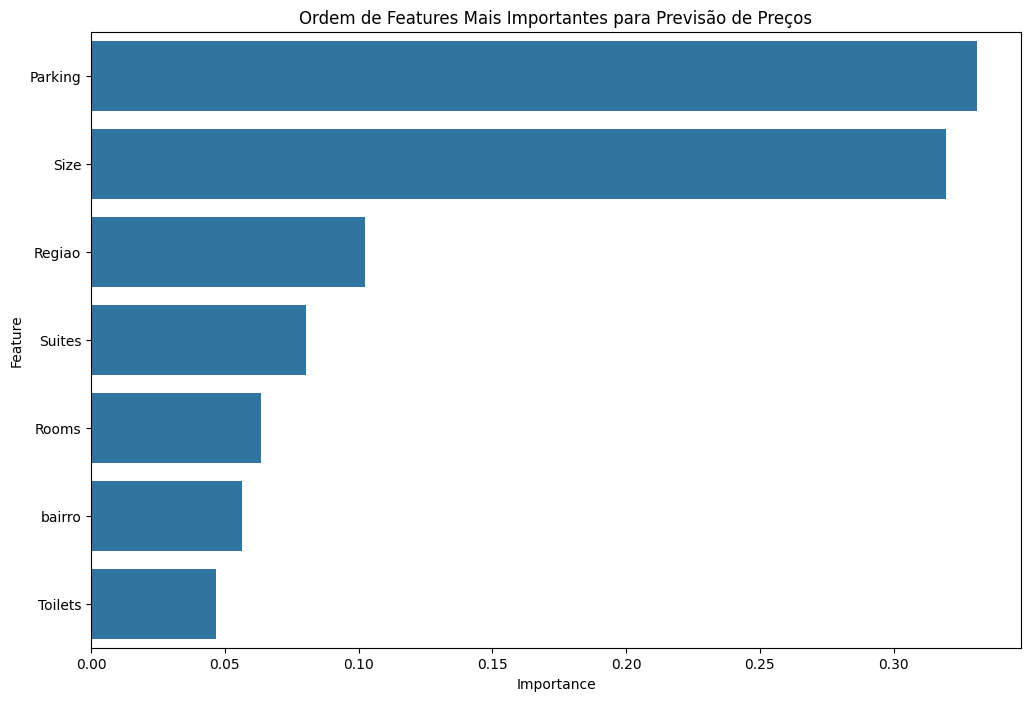

In [14]:
# Extrair importâncias
importances = xgb.feature_importances_

# Criar DataFrame de importância
feature_importances = pd.DataFrame({
    'feature': X_train_enc.columns,   # ou X_train_cat.columns, conforme seu caso
    'importance': importances}).sort_values(by='importance', ascending=False)

# Mostrar top 10
print(feature_importances.head(10))
from sklearn.pipeline import Pipeline

# Exemplo de como acessar o modelo e as features corretamente em um Pipeline
# Assumindo que o pipeline tem o nome 'model' para o XGBRegressor

# Se 'xgb' no seu código for, na verdade, o seu Pipeline:
# SUPOSTO CÓDIGO CORRETO (SE 'xgb' FOR UM PIPELINE)
if isinstance(xgb, Pipeline):
    # Acessa o estimador final (o XGBRegressor)
    xgb_model = xgb.named_steps['nome_da_etapa_do_modelo'] # Ex: 'xgb_regressor'
    # Extrai os nomes das features do ColumnTransformer
    importances = xgb_model.feature_importances_
    # ... e o resto do seu código

# DEFINA ISTO PRIMEIRO (assumindo que X_train_enc é seu dataset de treinamento processado)
all_features = X_train.columns
importances = xgb.feature_importances_ # Lembre-se de extrair os valores do modelo

# Então execute o DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Ordem de Features Mais Importantes para Previsão de Preços')
for p in ax.patches:
    # Formata o valor para 4 casas decimais para manter a precisão
    ax.annotate(f'{p.get_width():.4f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=10)
plt.show()

C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\1211554268.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')


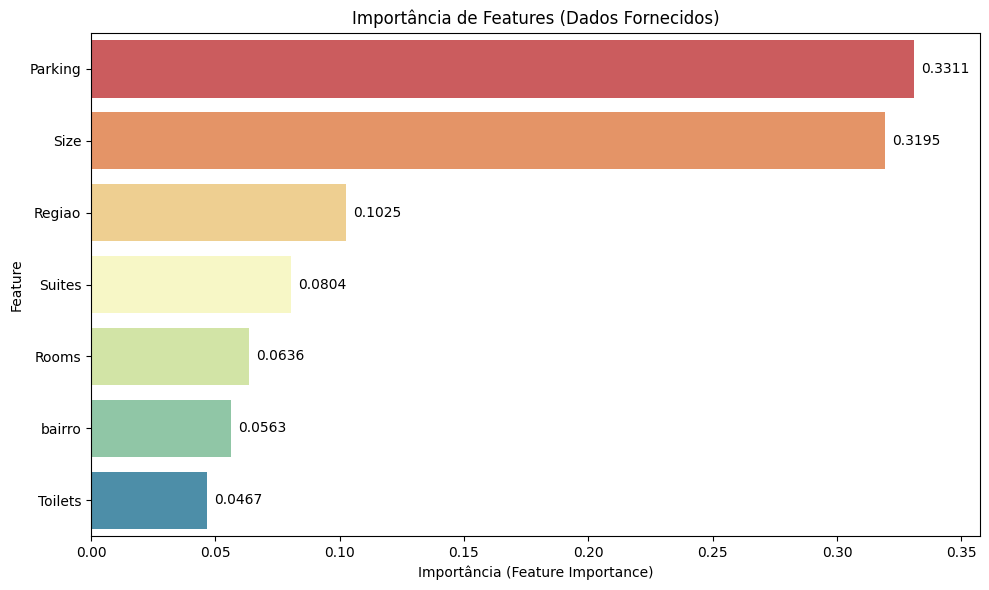


DataFrame utilizado:
   Feature  Importance
0  Parking    0.331054
1     Size    0.319508
2   Regiao    0.102477
3   Suites    0.080361
4    Rooms    0.063596
5   bairro    0.056267
6  Toilets    0.046736


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados fornecidos pelo usuário, corrigidos para criação de DataFrame
data = {
    'Feature': ['Parking', 'Size', 'Regiao', 'Suites', 'Rooms', 'bairro', 'Toilets'],
    'Importance': [0.331054, 0.319508, 0.102477, 0.080361, 0.063596, 0.056267, 0.046736]
}

importance_df = pd.DataFrame(data)

# Ordenar os dados para o gráfico (já estão ordenados, mas para garantir)
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# 1. Configurar o gráfico
plt.figure(figsize=(10, 6))

# Gerar o gráfico de barras e capturar o objeto 'ax' para rótulos
ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')

plt.title('Importância de Features (Dados Fornecidos)')
plt.xlabel('Importância (Feature Importance)')
plt.ylabel('Feature')

# 2. Adicionar RÓTULOS DE DADOS
for p in ax.patches:
    # Formata o valor para 4 casas decimais para visualização
    ax.annotate(f'{p.get_width():.4f}', 
                # Posição do rótulo: no final da barra (p.get_width())
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), # Pequeno deslocamento horizontal
                textcoords='offset points', 
                fontsize=10)

# Ajustar o limite do eixo X para garantir espaço para os rótulos
ax.set_xlim(right=importance_df['Importance'].max() * 1.08)

plt.tight_layout()
plt.show()

print("\nDataFrame utilizado:")
print(importance_df)